### Title: NN_with_HyperparameterOptimization
Author: Rhys Kilian

Date: 31-10-2018

This is one of many model files which were created in the hyperparameter optimisation process.

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import pandas as pd
pd.options.display.max_columns = 999

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Import models from scikit learn module
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.constraints import maxnorm

import numpy as np

/home/rhys/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Data Preparation

In [ ]:
# Read in the data
df_train = pd.read_csv('../../../0. Data/data_demand_cleaned_ML181026_train.csv', sep='\t')
df_train['period'] = pd.to_datetime(df_train['period'], format='%d/%m/%Y %H:%M')
df_train.sort_values(by='period', ascending=True, inplace=True)
df_train.tail()

In [3]:
# Read in the data
df_test = pd.read_csv('../../../0. Data/data_demand_cleaned_ML181026_test.csv', sep='\t')
df_test['period'] = pd.to_datetime(df_test['period'], format='%d/%m/%Y %H:%M')
df_test.sort_values(by='period', ascending=True, inplace=True)
df_test.head()

,period,demand,air_temp,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_334,lag_335,lag_336,lag_337,lag_338,lag_1006,lag_1007,lag_1008,lag_1009,lag_1010,lag_1679,lag_1680,lag_1681,lag_287,lag_288,lag_289,lag_672,lag_671,lag_673,dummy_Balckout,dummy_HeatWaves,dummy_Winter,dummy_Spring,dummy_Summer
0,2017-03-01 00:00:00,1852.77,34.00,46.93,1692.17,1743.35,1850.72,1975.58,2098.78,2209.24,2291.59,1400.48,1465.08,1493.41,1599.68,1429.60,1480.51,1540.91,1205.58,1261.73,1344.08,1175.69,1192.87,1362.40,1388.73,1491.46,1348.77,1355.61,1311.26,1418.21,1244.27,1201.42,1275.00,1100.42,1509.93,1401.17,1335.70,0,0,0,0,0
1,2017-03-01 00:30:00,1698.09,33.80,70.58,1852.77,1692.17,1743.35,1850.72,1975.58,2098.78,2209.24,1356.33,1400.48,1465.08,1493.41,1599.68,1429.60,1480.51,1133.37,1205.58,1261.73,1344.08,1175.69,1294.11,1362.40,1388.73,1491.46,1348.77,1243.51,1311.26,1418.21,1142.83,1201.42,1275.00,1401.17,1339.87,1509.93,0,0,0,0,0
2,2017-03-01 01:00:00,1629.32,33.60,119.52,1698.09,1852.77,1692.17,1743.35,1850.72,1975.58,2098.78,1357.86,1356.33,1400.48,1465.08,1493.41,1599.68,1429.60,1090.07,1133.37,1205.58,1261.73,1344.08,1250.07,1294.11,1362.40,1388.73,1491.46,1186.26,1243.51,1311.26,1063.67,1142.83,1201.42,1339.87,1276.82,1401.17,0,0,0,0,0
3,2017-03-01 01:30:00,1546.72,32.25,105.58,1629.32,1698.09,1852.77,1692.17,1743.35,1850.72,1975.58,1345.53,1357.86,1356.33,1400.48,1465.08,1493.41,1599.68,1070.76,1090.07,1133.37,1205.58,1261.73,1216.36,1250.07,1294.11,1362.40,1388.73,1147.69,1186.26,1243.51,1004.65,1063.67,1142.83,1276.82,1231.36,1339.87,0,0,0,0,0
4,2017-03-01 02:00:00,1511.15,30.90,139.16,1546.72,1629.32,1698.09,1852.77,1692.17,1743.35,1850.72,1320.15,1345.53,1357.86,1356.33,1400.48,1465.08,1493.41,1060.36,1070.76,1090.07,1133.37,1205.58,1226.75,1216.36,1250.07,1294.11,1362.40,1137.57,1147.69,1186.26,1008.12,1004.65,1063.67,1231.36,1186.95,1276.82,0,0,0,0,0


We now have to remove the 1681 rows which contain NaN values. Otherwise, we will get errors when trying to create our models.

In [4]:
# Remove NaN values
df_train.dropna(axis=0, inplace=True)
df_train.reset_index(drop=True,inplace=True)
df_test.dropna(axis=0, inplace=True)
df_test.reset_index(drop=True,inplace=True)

## 1.1 Train/Validation/Test Split

If we want a test set of approximately 20% then we need the last two months of data which are March 2017 and April 2017. This gives us a test set of approximately 18.5%. We do the same for the validation set which is January 2017 and February 2017. 

In [5]:
# # Create training and test sets
# split_point = 12910
# df_train_validate = df.iloc[0:split_point,:]
# df_test = df.iloc[split_point:,:]

In [6]:
# # Create training and validation sets
# split_point = 10078
# df_train = df_train_validate.iloc[0:split_point,:]
# df_validate = df_train_validate.iloc[split_point:,:]

In [7]:
# Shuffle 
from sklearn.utils import shuffle
df_train = shuffle(df_train)
#df_validate = shuffle(df_validate)
df_test = shuffle(df_test)

## 1.2 Convert Data

In [8]:
# Convert the data
X_train = df_train[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "lag_672","lag_671", "lag_673", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_train = df_train[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_train.shape))
print("Dimensions of X: {}".format(X_train.shape))

Dimensions of y: (12910, 1)
Dimensions of X: (12910, 40)


In [9]:
# # Convert the data
# X_validate = df_validate[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
# y_validate = df_validate[['demand']]

# # Print the dimensions of X and y 
# print("Dimensions of y: {}".format(y_validate.shape))
# print("Dimensions of X: {}".format(X_validate.shape))

In [10]:
# Convert the data
X_test = df_test[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "lag_672","lag_671", "lag_673", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_test = df_test[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_test.shape))
print("Dimensions of X: {}".format(X_test.shape))

Dimensions of y: (2909, 1)
Dimensions of X: (2909, 40)


## 1.3 Data Transformation
Making sure we only transform the numerical features and not the two dummy variables.

In [11]:
# We now create a list of numerical variables which will later be transformed
categorical = ['dummy_Balckout', 'dummy_HeatWaves', 'dummy_Winter', 'dummy_Spring', 'dummy_Summer']
exclude = categorical
numerical=[x for x in list(X_train.columns) if x not in exclude]

In [12]:
# Create numerical and categorical subsets of the data
X_train_numerical=X_train[numerical]
#X_validate_numerical=X_validate[numerical]
X_test_numerical=X_test[numerical]

X_train_categorical=X_train[categorical]
#X_validate_categorical=X_validate[categorical]
X_test_categorical=X_test[categorical]

In [13]:
# Use StandardScaler to transform numerical data
sc = StandardScaler().fit(X_train_numerical)
X_train_numerical_sc = sc.transform(X_train_numerical)
#X_validate_numerical_sc = sc.transform(X_validate_numerical)
X_test_numerical_sc = sc.transform(X_test_numerical)

# Add others here later

In [14]:
# Get the index from the previous numerical df
train_index = X_train_numerical.index
#validate_index = X_validate_numerical.index
test_index = X_test_numerical.index

# Create dataframe
X_train_numerical_sc = pd.DataFrame(X_train_numerical_sc, columns=numerical, index=train_index)
#X_validate_numerical_sc = pd.DataFrame(X_validate_numerical_sc, columns=numerical, index=validate_index)
X_test_numerical_sc = pd.DataFrame(X_test_numerical_sc, columns=numerical, index=test_index)

# Combine the data again to form the complete data set
X_train = pd.concat([X_train_numerical_sc, X_train_categorical], axis=1)
#X_validate = pd.concat([X_validate_numerical_sc, X_validate_categorical], axis=1)
X_test = pd.concat([X_test_numerical_sc, X_test_categorical], axis=1)

In [15]:
# Convert to arrays for modelling
X_train = X_train.values
#X_validate = X_validate.values
X_test = X_test.values

y_train = y_train.values
#y_validate = y_validate.values
y_test = y_test.values

# 2. Modelling

## 2.1 Functions for Scores

In [16]:
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def mae_cv_train(model):
    mae= -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

def mae_cv_test(model):
    mae= -cross_val_score(model, X_test, y_test, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

## 2.2 Create Function That Constructs A Neural Network

https://chrisalbon.com/deep_learning/keras/tuning_neural_network_hyperparameters/

https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_random_search/

In [17]:
# Find the size of the input
n_input = X_train.shape[1]

# Create function returning a compiled network
def create_network(optimizer='adam', layer1_units=15, layer2_units=15, layer3_units=15, init_mode='uniform', activation='relu', dropout_rate=0.0, weight_constraint=0):
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=layer1_units, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint), input_shape=(n_input,)))
    
    # Dropout
    network.add(Dropout(dropout_rate))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=layer2_units, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    
    # Dropout
    network.add(Dropout(dropout_rate))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=layer3_units, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    
    # Dropout
    network.add(Dropout(dropout_rate))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='linear', kernel_initializer=init_mode))

    # Compile neural network
    network.compile(loss='mean_squared_error', 
                    optimizer=optimizer, # Optimizer
                    metrics=['mean_absolute_error','mean_absolute_percentage_error']) # Accuracy performance metric
    
    # Return compiled network
    return network

## 2.3 Wrap Function In KerasClassifier

In [18]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasRegressor(build_fn=create_network, verbose=0)

## 2.4 Create Hyperparameter Search Space

In [19]:
# Create hyperparameter space
epochs = [500, 600, 700, 800, 900, 1200, 1600]
batches = [5, 10, 25, 50, 100, 200]
optimizers = ['Adam', 'Nadam']
init_mode = ['normal', 'glorot_normal', 'he_normal']
layer1_units = [10,15, 20, 25, 30, 35, 40, 50]
layer2_units = [5,10, 15, 20, 25, 30, 35, 40, 50]
layer3_units = [5,10, 15, 20, 25, 30, 35, 40, 50]
activation = ['relu']
weight_constraint = [1, 2, 3, 4]
dropout_rate = [0.2, 0.3, 0.4]

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init_mode=init_mode, layer1_units=layer1_units, layer2_units=layer2_units,layer3_units=layer3_units, activation=activation, dropout_rate=dropout_rate, weight_constraint=weight_constraint)

## 2.5 Conduct Grid Search

In [20]:
# Create grid search
#grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)

# Randomised grid search
grid = RandomizedSearchCV(neural_network, hyperparameters, random_state=1, n_iter=50, cv=3, verbose=0, n_jobs=-1)

# Fit grid search
grid_result = grid.fit(X_train, y_train)

## 2.6 Find Best Model’s Hyperparameters

In [21]:
# View hyperparameters of best neural network
grid_result.best_params_

{'activation': 'relu',
 'batch_size': 50,
 'dropout_rate': 0.2,
 'epochs': 1200,
 'init_mode': 'he_normal',
 'layer1_units': 25,
 'layer2_units': 35,
 'layer3_units': 35,
 'optimizer': 'Nadam',
 'weight_constraint': 3}

## 2.7 Display the Top 5 Models

In [ ]:
df_cv_results = pd.DataFrame(grid_result.cv_results_)
df_cv_results.sort_values(by=['rank_test_score']).head(75)

# 3. Model Validation
I will take the 3 best models and fit them manually. Then I will run them on the validation data to get their scores. Repeat the stuff from below

## 3.1 Model 1

In [ ]:
# Find the size of the input
n_input = X_train.shape[1]

# Define the model
model1 = Sequential()
model1.add(Dense(25, input_dim=n_input, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm(3)))
model1.add(Dropout(0.2))
model1.add(Dense(35, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm(3)))
model1.add(Dropout(0.2))
model1.add(Dense(35, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm(3)))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='linear', kernel_initializer='he_normal')) 

# Compile the model
model1.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])

# Fit the model
validation_data = (X_test, y_test)
history1 = model1.fit(X_train, y_train, epochs=1200, batch_size=50, validation_data=validation_data)

# Calculate the scores
scores1 = model1.evaluate(X_test, y_test)

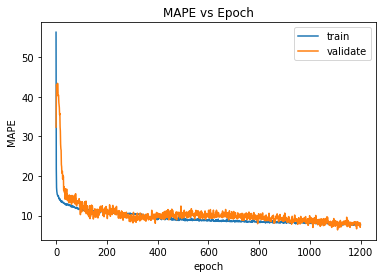

In [24]:
# summarize history for loss
plt.plot(history1.history['mean_absolute_percentage_error'])
plt.plot(history1.history['val_mean_absolute_percentage_error'])
#plt.ylim(0, 10)
plt.title('MAPE vs Epoch')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [25]:
print("\n%s: %.2f%%" % (model1.metrics_names[2], scores1[2]))


mean_absolute_percentage_error: 7.79%


In [26]:
print("\n%s: %.2f(MW)" % (model1.metrics_names[1], scores1[1])) 


mean_absolute_error: 102.33(MW)


## 3.2 Model 2

In [ ]:
# Find the size of the input
n_input = X_train.shape[1]

# Define the model
model2 = Sequential()
model2.add(Dense(25, input_dim=n_input, activation='relu', kernel_initializer='he_normal'))
model2.add(Dropout(0))
model2.add(Dense(25, activation='relu', kernel_initializer='he_normal'))
model2.add(Dropout(0))
model2.add(Dense(1, activation='linear', kernel_initializer='he_normal')) 

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])

# Fit the model
validation_data = (X_validate, y_validate)
history2 = model2.fit(X_train, y_train, epochs=700, batch_size=5, validation_data=validation_data)

# Calculate the scores
scores2 = model2.evaluate(X_validate, y_validate)

In [ ]:
# summarize history for loss
plt.plot(history2.history['mean_absolute_percentage_error'])
plt.plot(history2.history['val_mean_absolute_percentage_error'])
#plt.ylim(0, 10)
plt.title('MAPE vs Epoch')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
print("\n%s: %.2f%%" % (model2.metrics_names[2], scores2[2]))
print("\n%s: %.2f(MW)" % (model2.metrics_names[1], scores2[1])) 

## 3.3. Model 3

In [ ]:
# Find the size of the input
n_input = X_train.shape[1]

# Define the model
model3 = Sequential()
model3.add(Dense(30, input_dim=n_input, activation='relu', kernel_initializer='glorot_normal'))
model3.add(Dropout(0))
model3.add(Dense(35, activation='relu', kernel_initializer='glorot_normal'))
model3.add(Dropout(0))
model3.add(Dense(1, activation='linear', kernel_initializer='glorot_normal')) 

# Compile the model
model3.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])

# Fit the model
validation_data = (X_validate, y_validate)
history3 = model3.fit(X_train, y_train, epochs=300, batch_size=25, validation_data=validation_data)

# Calculate the scores
scores3 = model3.evaluate(X_validate, y_validate)

In [ ]:
# summarize history for loss
plt.plot(history3.history['mean_absolute_percentage_error'])
plt.plot(history3.history['val_mean_absolute_percentage_error'])
#plt.ylim(0, 10)
plt.title('MAPE vs Epoch')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
print("\n%s: %.2f%%" % (model3.metrics_names[2], scores3[2]))
print("\n%s: %.2f(MW)" % (model3.metrics_names[1], scores3[1])) 